In [2]:
import os
import glob
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
from keras.models import Sequential, Model, load_model
from keras.applications.vgg16 import VGG16,preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import Callback, EarlyStopping
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from keras import backend as K
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
print(os.listdir("chest_xray/"))

['.DS_Store', 'patient side', 'test', 'train', 'val', '__MACOSX']


In [4]:
data_dir = Path("chest_xray/")
train_dir = data_dir/'train'
val_dir = data_dir/'val'
test_dir = data_dir/'test'

In [5]:
def load_train():
    normal_cases_dir = train_dir/'NORMAL'
    pneumonia_cases_dir = train_dir/'PNEUMONIA'

    normal_cases = normal_cases_dir.glob('*.jpg')
    pneumonia_cases = pneumonia_cases_dir.glob('*jpg')
    train_data = []
    train_label = []
    for img in normal_cases:
        train_data.append(img)
        train_label.append('NORMAL')
    for img in pneumonia_cases:
        train_data.append(img)
        train_label.append('PNEUMONIA')
    df = pd.DataFrame(train_data)
    df.columns = ['images']
    df['labels']= train_label
    df = df.sample(frac=1).reset_index(drop=True)
    return df

In [6]:
train_data = load_train()
train_data.shape

(7081, 2)

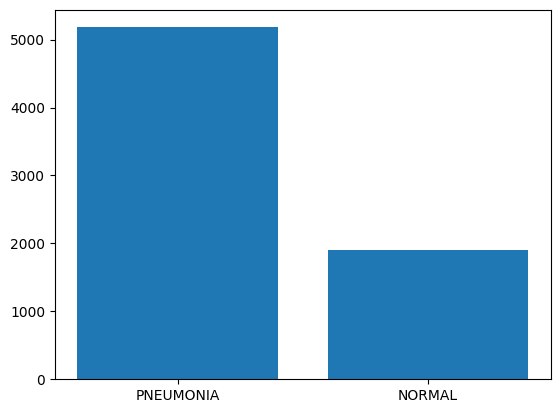

In [7]:
plt.bar(train_data['labels'].value_counts().index, train_data['labels'].value_counts().values)
plt.show()

In [8]:
def plot(image_batch, label_batch):
    plt.figure(figsize=(10,6))
    for i in range(15):
        ax = plt.subplot(3,5,i+1)
        img = cv2.imread(str(image_batch[i]))
        img = cv2.resize(img, (224,224))
        plt.imshow(img)
        plt.title(label_batch[i])
        plt.axis('off')

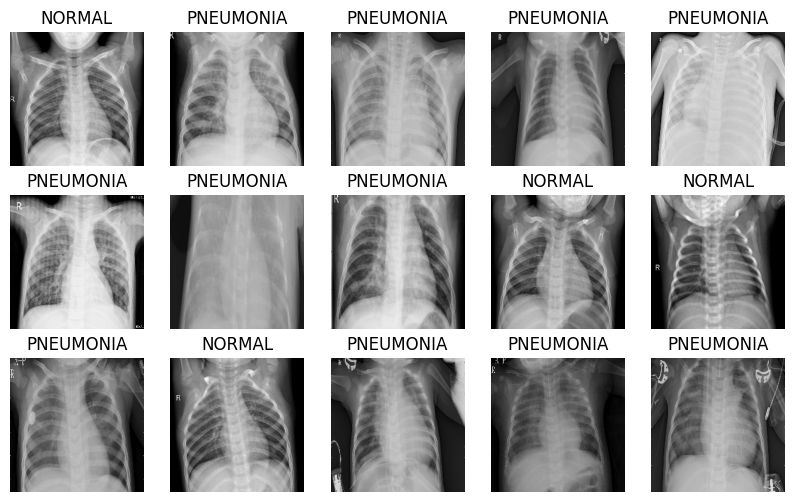

In [9]:
plot(train_data['images'], train_data['labels'])

In [10]:
def prepare_and_load(isval=True):
    if isval==True:
        normal_dir = val_dir/'NORMAL'
        pneumonia_dir = val_dir/'PNEUMONIA'
    else:
        normal_dir=test_dir/'NORMAL'
        pneumonia_dir = test_dir/'PNEUMONIA'
    normal_cases  = normal_dir.glob("*.jpg")
    pneumonia_cases  = pneumonia_dir.glob("*.jpg")
    data, labels=([] for x in range(2))
    def prepare(case):
        for img in case:
            img = cv2.imread(str(img))
            img = cv2.resize(img, (224,224))
            if img.shape[2]==1:
                img = np.dstack([img,img,img])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img.astype(np.float32)/255.
            if case==normal_cases:
                label=to_categorical(0,num_classes=2)
            else:
                label=to_categorical(1,num_classes=2)
            data.append(img)
            labels.append(label)
        return data,labels
    prepare(normal_cases)
    d,l = prepare(pneumonia_cases)
    d=np.array(d)
    l=np.array(l)
    return d,l

In [11]:
val_data, val_labels = prepare_and_load(isval=True)
test_data, test_labels = prepare_and_load(isval=False)
print('NUMBER OF TEST IMAGES ---> ', len(test_data))
print('NUMBER OF VALIDATION IMAGES ---> ', len(val_data))

NUMBER OF TEST IMAGES --->  2316
NUMBER OF VALIDATION IMAGES --->  2315


In [12]:
def data_gen(data, batch_size):
    n = len(data)
    steps = n//batch_size

    batch_data = np.zeros((batch_size,224,224,3),dtype=np.float32)
    batch_labels = np.zeros((batch_size,2),dtype=np.float32)

    indices = np.arange(n)

    i=0
    while True:
        np.random.shuffle(indices)
        count = 0
        next_batch = indices[(i*batch_size):(i+1)*batch_size]
        for j, idx in enumerate(next_batch):
            img_name = data.iloc[idx]['images']
            label = data.iloc[idx]['labels']
            if label == 'NORMAL':
                label = 0
            else:
                label = 1

            encoded_label = to_categorical(label,num_classes=2)

            img = cv2.imread(str(img_name))
            img = cv2.resize(img, (224,224))

            if img.shape[2]==1:
                img = np.dstack([img,img,img])

            orig_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            orig_img  = img.astype(np.float32)/255.

            batch_data[count] = orig_img
            batch_labels[count] = encoded_label

            count+=1
            
            if count==batch_size-1:
                break

        i+=1
        yield batch_data, batch_labels

        if i>=steps:
            i=0

In [13]:

model = Sequential()
model.add(Conv2D(32,(3,3),input_shape=(224,224,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dense(2))
model.add(Activation('softmax'))

In [14]:
batch_size = 16
nb_epochs = 3

In [15]:
train_data_gen = data_gen(data = train_data, batch_size=batch_size)
nb_train_steps = train_data.shape[0]//batch_size

print("NUMBER OF TRAINING AND VALIDATION STEPS: {} AND {}".format(nb_train_steps,len(val_data)))

NUMBER OF TRAINING AND VALIDATION STEPS: 442 AND 2315


In [16]:
model.compile(loss='binary_crossentropy', 
optimizer='RMSprop', 
metrics=['accuracy'])

history = model.fit(train_data_gen,epochs=nb_epochs, 
steps_per_epoch=nb_train_steps, 
validation_data=(val_data, val_labels))

Epoch 1/3
442/442 [==============================] - 525s 1s/step - loss: 0.2880 - accuracy: 0.8665 - val_loss: 0.1396 - val_accuracy: 0.9499
Epoch 2/3
442/442 [==============================] - 500s 1s/step - loss: 0.1393 - accuracy: 0.8988 - val_loss: 0.1917 - val_accuracy: 0.9274
Epoch 3/3
442/442 [==============================] - 539s 1s/step - loss: 0.1127 - accuracy: 0.9101 - val_loss: 0.1813 - val_accuracy: 0.9374


In [17]:
def vgg16_model(num_classes=None):
    model = VGG16(weights='imagenet', include_top=True, input_shape=(224,224,3))

    x = Dense(1024, activation='relu')(model.layers[-4].output)
    x = Dropout(0.7)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(2, activation='softmax')(x)
    model = Model(model.input,x)

    return model

In [21]:
vgg_conv = vgg16_model(2)
for layer in vgg_conv.layers[:-10]:
    layer.trainable = False

In [22]:
opt = Adam(lr=0.0001, decay=1e-5)
vgg_conv.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=opt)

In [23]:
from keras.models import load_model
import pickle 

history = vgg_conv.fit_generator(train_data_gen, epochs=nb_epochs, 
steps_per_epoch=nb_train_steps, validation_data=(val_data, val_labels),
class_weight = {0:1.0,1:0.4})

# vgg_conv.save('model12.h5')
with open('model12.pkl', 'wb') as file:
    pickle.dump(vgg_conv, file)

C:\Users\pc\AppData\Local\Temp\ipykernel_3736\2171848651.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = vgg_conv.fit_generator(train_data_gen, epochs=nb_epochs,


Epoch 1/3
442/442 [==============================] - 3915s 9s/step - loss: 0.3148 - accuracy: 0.7313 - val_loss: 0.1357 - val_accuracy: 0.9473
Epoch 2/3
442/442 [==============================] - 4279s 10s/step - loss: 0.1168 - accuracy: 0.8959 - val_loss: 0.1162 - val_accuracy: 0.9521
Epoch 3/3
442/442 [==============================] - 3748s 8s/step - loss: 0.0821 - accuracy: 0.9183 - val_loss: 0.1277 - val_accuracy: 0.9542


INFO:tensorflow:Assets written to: ram://c11e0eb7-5a2f-49fe-b7fd-4f658345df06/assets


INFO:tensorflow:Assets written to: ram://c11e0eb7-5a2f-49fe-b7fd-4f658345df06/assets


In [24]:
with open('model12.pkl', 'rb') as file:
    vgg_conv = pickle.load(file)

FileNotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for ram://636d348e-4de0-45b9-b41b-20806be4bcea/variables/variables
 You may be trying to load on a different device from the computational device. Consider setting the `experimental_io_device` option in `tf.saved_model.LoadOptions` to the io_device such as '/job:localhost'.

In [ ]:
# model = load_model('model12.h5')

In [ ]:
loss,acc = model.evaluate(test_data,test_labels,batch_size=16)
print('LOSS: ',loss)
print('ACCURACY: ',acc)

 17/145 [==>...........................] - ETA: 14:37 - loss: 0.0440 - accuracy: 0.9926

In [27]:
pred = model.predict(test_data,batch_size=16)
pred = np.argmax(pred, axis=-1)
print(pred)

145/145 [==============================] - 980s 7s/step
[0 0 0 ... 1 1 1]


In [28]:
labels = np.argmax(test_labels, axis=-1)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(labels,pred))

In [29]:
labels

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

<AxesSubplot: >

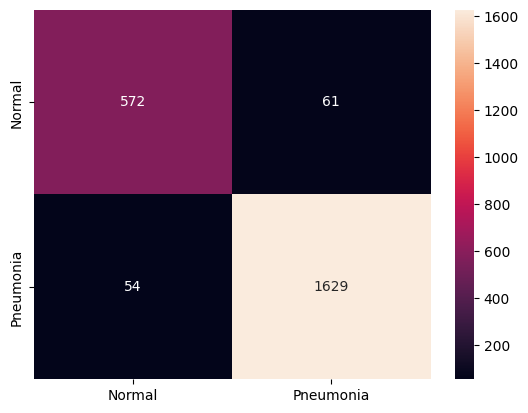

In [48]:
import seaborn as sns
cm = confusion_matrix(labels, pred)
sns.heatmap(cm, annot=True, fmt = 'g', xticklabels = ['Normal', 'Pneumonia'], yticklabels= ['Normal', 'Pneumonia'])

In [73]:
from sklearn.metrics import accuracy_score
print(accuracy_score(labels, pred, normalize=True, sample_weight=None))

0.9503454231433506


1/1 [==============================] - 1s 586ms/step
[0]


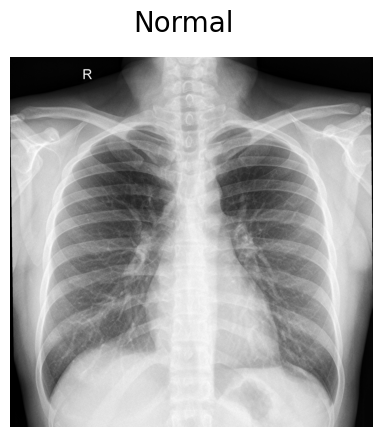

In [47]:
import matplotlib.image as mpimg
image_path = 'chest_xray\\test\\NORMAL\\test_norm_88.jpg'
image = mpimg.imread(image_path)

test_image = load_img(image_path, target_size = (224, 224))
test_image = img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
predi = model.predict(test_image)
predict = np.argmax(predi, axis=-1)
print(predict)
if predict == 0:
    prediction = 'Normal'
else:
    prediction = 'Pneumonia +VE'

plt.imshow(image);plt.suptitle(prediction, fontsize = 20);plt.axis("off");plt.show()

In [43]:
predi

array([[1.0000000e+00, 1.9560117e-12]], dtype=float32)

In [75]:
prob = model.predict(test_data)

73/73 [==============================] - 856s 12s/step


In [1]:
prob

NameError: name 'prob' is not defined

In [76]:
prob.shape

(2316, 2)

In [77]:
prob = np.delete(prob, -1, axis=1)
prob.shape

(2316, 1)

In [78]:
len(prob), len(labels)

(2316, 2316)

(0.49, 1.01)

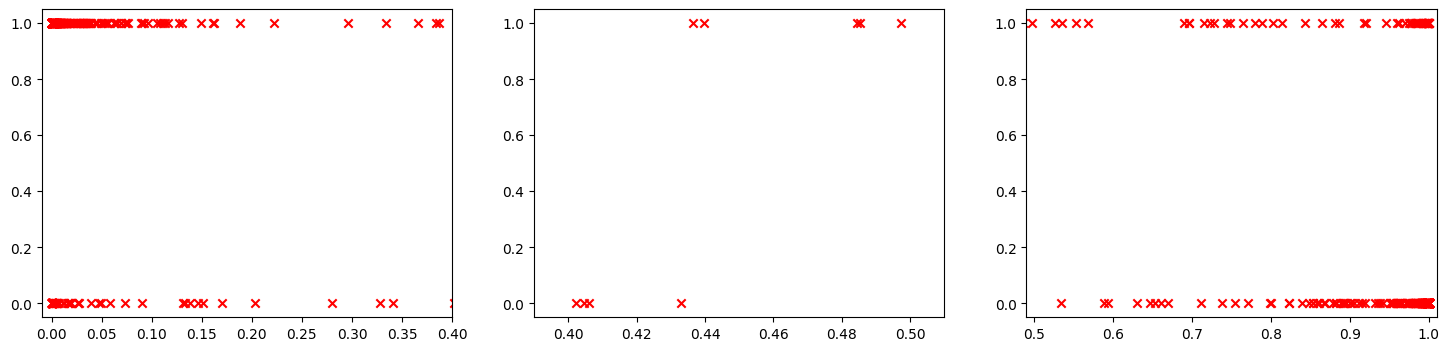

In [79]:
plt.figure(figsize=(18,4))
plt.subplot(1,3,1)
plt.scatter(prob, labels, marker = 'x', color = 'r');plt.xlim([-0.01, 0.4])
plt.subplot(1,3,2)
plt.scatter(prob, labels, marker = 'x', color = 'r');plt.xlim([0.39, 0.51])
plt.subplot(1,3,3)
plt.scatter(prob, labels, marker = 'x', color = 'r');plt.xlim([0.49, 1.01])